# Building a Multi-Agent Financial Analysis System using LangGraph

In this tutorial, we will build a multi-agent financial analysis system using LangGraph. This system utilizes the multi-agent supervisor pattern, where a supervisor agent orchestrates multiple specialized agents to accomplish complex tasks.

In addition to the supervisor, our system will include the following agents:

- Web Search Agent: Equipped with the Tavily web search tool to gather information from the web.
- Financial Analysis Agent: Uses the Alpha Vantage API to access stock market data.
- Code Agent: Has access to a Python REPL for generating code for data visualization.


### Imports and Setup
Let's start by importing the necessary libraries and setting up the environment.


In [71]:
# Imports
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.alpha_vantage import AlphaVantageAPIWrapper
from langchain_experimental.tools import PythonREPLTool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict
from pydantic import BaseModel
import operator
import functools

# Load environment variables
from dotenv import load_dotenv
_ = load_dotenv()


### Defining the Model

As with the previous tutorials, we will use the `gpt-4o` model.

In [72]:
# Define the LLM
llm = ChatOpenAI(model="gpt-4o", temperature=0)

### Defining the Tools

#### 1. Current Date Tool
We define a simple tool to get the current date. This can be useful for time-based queries.

In [73]:
from langchain_core.tools import tool
from datetime import datetime

@tool
def get_current_date():
    """Returns the current date and time. Use this tool first for any time-based queries."""
    return f"The current date is: {datetime.now().strftime('%d %B %Y')}"

#### 2. Tavily Web Search Tool
We initialize the Tavily search tool for the Web Search Agent.


In [74]:
# Tavily Search Tool
tavily_tool = TavilySearchResults(max_results=5)

#### 3. Alpha Vantage Tool
We create a custom tool for the Alpha Vantage API to fetch financial data.

In [78]:
# define custom tool for alpha vantage
from langchain_core.tools import BaseTool

class AlphaVantageQueryRun(BaseTool):
    """Tool that queries the Alpha Vantage API."""

    name: str = "alpha_vantage"
    description: str = (
        "A wrapper around Alpha Vantage API. "
        "Useful for getting financial information about stocks, "
        "forex, cryptocurrencies, and economic indicators. "
        "Input should be the name of the stock ticker."
    )
    api_wrapper: AlphaVantageAPIWrapper = AlphaVantageAPIWrapper()

    def _run(self, ticker: str) -> str:
        """Use the tool."""
        return self.api_wrapper._get_time_series_daily(ticker)

alpha_vantage_tool = AlphaVantageQueryRun()


#### 4. Python REPL Tool
We initialize the Python REPL tool for the Code Agent. Note: This tool can execute arbitrary code. Use with caution.

In [79]:
python_repl_tool = PythonREPLTool()

### Creating the Agents
We will create three agents, each with specific roles and tools.

#### 1. Web Search Agent

In [127]:
# Web Search Agent
system_prompt = "You are a web search agent. Your role is to use web search tools to find information and return comprehensive answers to queries."
web_search_agent = create_react_agent(llm, tools=[tavily_tool, get_current_date], state_modifier=system_prompt)

#### 2. Financial Analysis Agent

In [128]:
# Financial Analysis Agent
system_prompt = "You are a financial analysis agent. Your role is to use the Alpha Vantage tool to gather financial data and provide concise, informative answers. " \
               "Do not generate charts or plots. Only use the tools provided to you and return a clear, text-based analysis or result."
financial_agent = create_react_agent(llm, tools=[alpha_vantage_tool, get_current_date], state_modifier=system_prompt)

#### 3. Code Agent

In [129]:
# Code Agent
system_prompt = "You are a visualization agent. Your role is to create visual representations of data using Python. " \
                "Only use the Python REPL tool provided to generate plots, charts, or other visualizations. " \
                "Do not perform any data analysis or gather information. Your sole purpose is to take the given data " \
                "and create appropriate visualizations. Return the code for the visualization without executing it."
code_agent = create_react_agent(llm, tools=[python_repl_tool], state_modifier=system_prompt)


#### 4. Supervisor Agent
The supervisor agent manages the workflow by deciding which agent should handle the next task.


In [141]:
# Define team members
members = {
    "WebSearchAgent": "An agent that performs web searches to gather information",
    "FinancialAgent": "An agent that analyzes financial data using Polygon tools to acquire stock market information.",
    "CodeAgent": "An agent that executes Python code and performs computations. Use this to generate plots and tables."
}

# Supervisor Prompt Template
system_prompt = (
    "You are a highly efficient supervisor managing a collaborative conversation between specialized agents:"
    "\n{members_description}"
    "\nYour role is to:"
    "\n1. Analyze the user's request and the ongoing conversation."
    "\n2. Determine which agent is best suited to handle the next task."
    "\n3. Ensure a logical flow of information and task execution."
    "\n4. Correctly detect task completion and responsd with 'FINISH', especially when visual outputs like plots are generated."
    "   For example, if the CodeAgent returns the code for drawing a plot or visualization, consider the task complete if drawing a plot was the objective."
    "   If the CodeAgent returns an image, consider the plot as drawn and the task complete if drawing a plot was the objective."
    "\n5. Facilitate seamless transitions between agents as needed."
    "\n6. Conclude the process by responding with 'FINISH' when all objectives are met."
    " Remember, each agent has unique capabilities, so choose wisely based on the current needs of the task."
)

members_description = "\n".join([f"- {k}: {v}" for k, v in members.items()])

system_prompt = system_prompt.format(members_description=members_description)

# Possible options for the supervisor
options = ["FINISH"] + list(members.keys())

# Define the supervisor's output schema
class RouteResponse(BaseModel):
    """
    The supervisor's response to the user's request.
    """
    next: Literal["FINISH", "WebSearchAgent", "FinancialAgent", "CodeAgent"]

# Supervisor Prompt
supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Based on the conversation, who should act next? Choose one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join([f"{k}: {v}" for k, v in members.items()]))

# Supervisor Agent Function
def supervisor_agent(state):
    supervisor_chain = supervisor_prompt | llm.with_structured_output(RouteResponse)
    return supervisor_chain.invoke(state)

### Constructing the Graph
We define the state, nodes, and edges for our graph.

In [142]:
# Define the state
class AgentState(TypedDict):
    messages: Annotated[Sequence[HumanMessage], operator.add]
    next: str

In [143]:
# Helper Function for Agent Nodes
def agent_node(state, agent, name):
    result = agent.invoke({"messages": state["messages"]})
    # Add the agent's response to the conversation
    return {
        "messages": [AIMessage(content=result["messages"][-1].content, name=name)]
    }

#### Defining the Agent Nodes

In [144]:
# Web Search Node
web_search_node = functools.partial(agent_node, agent=web_search_agent, name="WebSearchAgent")

# Financial Analysis Node
financial_node = functools.partial(agent_node, agent=financial_agent, name="FinancialAgent")

# Code Agent Node
code_node = functools.partial(agent_node, agent=code_agent, name="CodeAgent")


#### Building the Graph

In [145]:
# Initialize the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("WebSearchAgent", web_search_node)
workflow.add_node("FinancialAgent", financial_node)
workflow.add_node("CodeAgent", code_node)
workflow.add_node("Supervisor", supervisor_agent)

# Define edges
for member in members:
    # Each agent reports back to the supervisor
    workflow.add_edge(member, "Supervisor")

# Supervisor decides the next agent or to finish
conditional_map = {member: member for member in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("Supervisor", lambda x: x["next"], conditional_map)

# Entry point
workflow.add_edge(START, "Supervisor")

# Compile the graph with memory checkpointing
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)


#### Visualizing the Graph

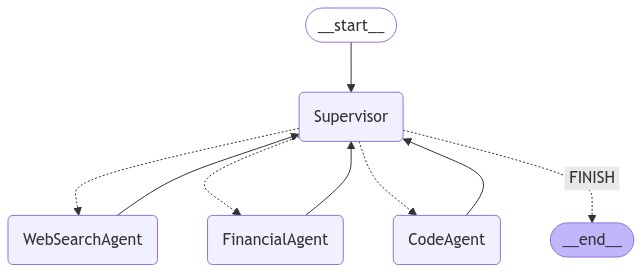

In [135]:
from IPython.display import display, Image

# Visualize the chatbot's workflow
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass  # Visualization requires additional dependencies

### Running the Multi-Agent System

We run the multi-agent system with different queries to demonstrate its capabilities.


In [136]:
# Helper Function to Process Events
def process_event(event):
    print(event)
    if "__end__" not in event:
        if "messages" in event:
            agent_name = event["messages"][-1].name
            content = event["messages"][-1].content
            print(f"=== {agent_name} ===\n{content}\n")
        elif "next" in event:
            print(f"Supervisor decides the next agent: {event['next']}\n")


#### Example 1: Fetching the Latest Closing Stock Price
User Request: "What was the last closing stock price of AAPL?"


In [138]:
# Be sure to use different thread_ids for different runs
config = {"configurable": {"thread_id": "1"}}

# Run the graph
events = graph.stream(
    {"messages": [HumanMessage(content="What was the last closing stock price of AAPL?")]},
    config=config
)

for event in events:
    process_event(event)


{'Supervisor': {'next': 'FinancialAgent'}}
{'FinancialAgent': {'messages': [AIMessage(content='The last closing stock price of Apple Inc. (AAPL) was $235.00 on October 18, 2024.', additional_kwargs={}, response_metadata={}, name='FinancialAgent')]}}
{'Supervisor': {'next': 'FINISH'}}


#### Example 2: Summarizing Latest News
User Request: "Summarize the latest news about Tesla's stock performance."


In [139]:
config = {"configurable": {"thread_id": "2"}}

# Run the graph
events = graph.stream(
    {"messages": [HumanMessage(content="Summarize the latest news about Tesla's stock performance.")]},
    config=config
)

for event in events:
    process_event(event)


{'Supervisor': {'next': 'WebSearchAgent'}}
{'WebSearchAgent': {'messages': [AIMessage(content="As of October 2024, Tesla's stock performance has been influenced by several key events and financial updates:\n\n1. **Stock Price Movement**: Tesla's stock experienced a slight increase earlier in the week, but it remains 8% lower compared to its value before a recent robotaxi event. This suggests some volatility in the stock price following the event.\n\n2. **Financial Performance**: In 2023, Tesla reported a revenue of $96.77 billion, marking an 18.80% increase from the previous year. This growth reflects strong financial performance, which could impact investor sentiment positively.\n\n3. **Upcoming Earnings Report**: Tesla is set to release its third-quarter results on October 23, 2024. This upcoming report is likely to cause further volatility in Tesla's stock price as investors react to the new financial data.\n\n4. **Analyst Expectations**: Analysts have been adjusting their expectati

#### Example 3: Generating a Stock Price Plot
User Request: "Draw a plot of the closing stock prices of AAPL over the last week, with the x-axis being the closing dates."


{'Supervisor': {'next': 'FinancialAgent'}}
{'FinancialAgent': {'messages': [AIMessage(content='Here are the closing stock prices for AAPL over the last week:\n\n- **October 18, 2024**: $235.00\n- **October 17, 2024**: $232.15\n- **October 16, 2024**: $231.78\n- **October 15, 2024**: $233.85\n- **October 14, 2024**: $231.30\n- **October 11, 2024**: $227.55\n\nThese are the closing prices for the most recent trading days. If you need further analysis or information, feel free to ask!', additional_kwargs={}, response_metadata={}, name='FinancialAgent')]}}
{'Supervisor': {'next': 'CodeAgent'}}


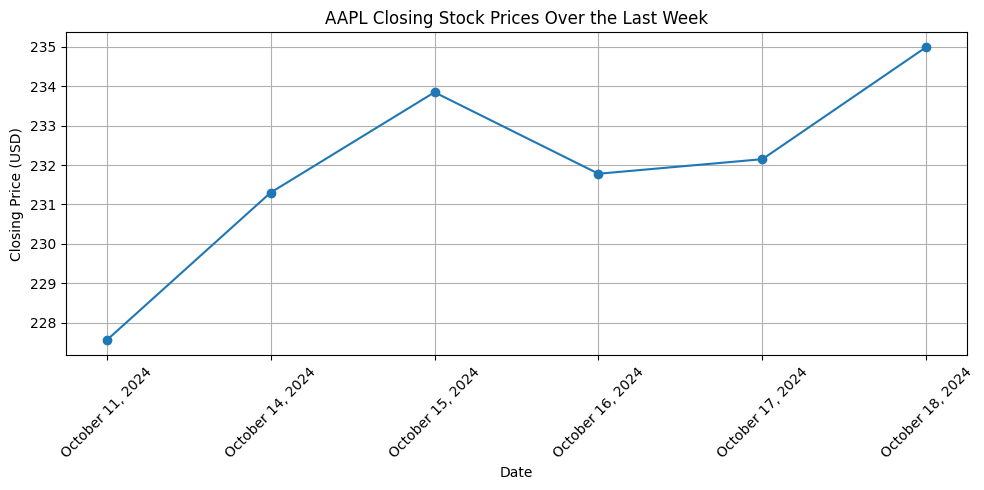

{'CodeAgent': {'messages': [AIMessage(content="Here's the code to plot the closing stock prices of AAPL over the last week:\n\n```python\nimport matplotlib.pyplot as plt\n\n# Dates and closing prices for AAPL\nclosing_dates = ['October 11, 2024', 'October 14, 2024', 'October 15, 2024', 'October 16, 2024', 'October 17, 2024', 'October 18, 2024']\nclosing_prices = [227.55, 231.30, 233.85, 231.78, 232.15, 235.00]\n\n# Plotting the data\nplt.figure(figsize=(10, 5))\nplt.plot(closing_dates, closing_prices, marker='o')\nplt.title('AAPL Closing Stock Prices Over the Last Week')\nplt.xlabel('Date')\nplt.ylabel('Closing Price (USD)')\nplt.xticks(rotation=45)\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n```\n\nThis code will create a line plot with markers for each closing price, showing the trend over the specified dates.", additional_kwargs={}, response_metadata={}, name='CodeAgent')]}}
{'Supervisor': {'next': 'FINISH'}}


In [146]:
config = {"configurable": {"thread_id": "3"}}

# Run the graph
events = graph.stream(
    {"messages": [HumanMessage(content="Draw a plot of the closing stock prices of AAPL over the last week, with the x axis being the closing dates.")]},
    config=config
)

for event in events:
    process_event(event)

In [ ]:

By following this tutorial, you've built a sophisticated multi-agent system capable of handling complex financial analysis tasks by leveraging the power of LangGraph and specialized agents.